In [4]:
import sys  
sys.path.insert(0, '/Users/tliaudat/Documents/PhD/codes/WF_PSF/')

import numpy as np
import scipy.signal as spsig
import scipy.interpolate as sinterp
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import PIL
import time
from tqdm import tqdm


%pylab inline

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Import from the wf-psf module
from py_code.SimPSFToolkit import SimPSFToolkit
from py_code.GenFieldPSF import GenFieldPSF


Populating the interactive namespace from numpy and matplotlib


In [5]:
# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# plt.rc('text', usetex=True)
# font = {'family' : 'serif',
#         'weight' : 'bold',
#         'size'   : 20}
font = {'size'   : 14}
mpl.rc('font', **font)


output_path = './figures/'



# New PSF field generator

In [6]:
class GenPolyFieldPSF(object):
    """Generate PSF field with polynomial vairiations of Zernike coefficients."""
    def __init__(self, sim_psf_toolkit, d_max=2, grid_points=[4, 4], max_order=45,
                 x_lims=[0, 1e3], y_lims=[0, 1e3], n_bins=35,
                 lim_max_wfe_rms=None, verbose=False):
        # Input attributes
        self.sim_psf_toolkit = sim_psf_toolkit
        self.max_order = max_order
        self.d_max = d_max
        self.x_lims = x_lims
        self.y_lims = y_lims
        self.grid_points = grid_points
        self.n_bins = n_bins
        self.verbose = verbose
        if lim_max_wfe_rms is None:
            self.lim_max_wfe_rms = sim_psf_toolkit.max_wfe_rms
        else:
            self.lim_max_wfe_rms = lim_max_wfe_rms

        # Class attributes
        self.C_poly = None
        self.WFE_RMS = None
        
        # Build coefficient polynomial matric
        self.build_poly_coefficients()
        

    def scale_positions(self, xv_flat, yv_flat):
        # Scale positions to the square [-1,1] x [-1,1]
        scaled_x = (xv_flat - self.x_lims[0]) / (self.x_lims[1] - self.x_lims[0])
        scaled_x = (scaled_x - 0.5) * 2
        scaled_y = (yv_flat - self.y_lims[0]) / (self.y_lims[1] - self.y_lims[0])
        scaled_y = (scaled_y - 0.5) * 2
        
        return scaled_x, scaled_y

    def poly_mat_gen(self, xv_flat, yv_flat):
        """ Generate polynomial matrix of positions.
        
        Parameters
        ----------
        xv_flat: np.ndarray (dim,)
            x positions.
        yv_flat: np.ndarray (dim,)
            y positions.
        """
        n_mono = (self.d_max + 1) * (self.d_max + 2) // 2
        if np.isscalar(xv_flat):
            Pi = np.zeros((n_mono, 1))
        else:
            Pi = np.zeros((n_mono, xv_flat.shape[0]))

        # Scale positions to the square [-1,1] x [-1,1]
        scaled_x, scaled_y = self.scale_positions(xv_flat, yv_flat)

        for d in range(self.d_max + 1):
            row_idx = d * (d + 1) // 2
            for p in range(d + 1):
                Pi[row_idx + p, :] = scaled_x ** (d - p) * scaled_y ** p

        return Pi

    def zernike_poly_gen(self, xv_flat, yv_flat):
        """ Generate zernike values from positions.
        
        Parameters
        ----------
        xv_flat: np.ndarray (dim,)
            x positions.
        yv_flat: np.ndarray (dim,)
            y positions.
        """
        # Generate the polynomial matrix
        Pi_samples = self.poly_mat_gen(xv_flat, yv_flat)

        return self.C_poly @ Pi_samples


    def build_poly_coefficients(self):
        """Build a polynomial coefficient matrix."""
        ## Choose the anchor points on a regular grid
        x = np.linspace(self.x_lims[0], self.x_lims[1], num=self.grid_points[0], endpoint=True)
        y = np.linspace(self.y_lims[0], self.y_lims[1], num=self.grid_points[1], endpoint=True)
        # Build mesh
        xv_grid, yv_grid = np.meshgrid(x, y)
        
        ## Random position shift
        # It is done as a random shift defined in a
        # square centred in each grid position so that there is
        # no overlaping between the squares.
        xv_rand = np.random.rand(self.grid_points[0], self.grid_points[1]) 
        yv_rand = np.random.rand(self.grid_points[0], self.grid_points[1]) 
        # Calculate the shift length
        x_step = (self.x_lims[1] - self.x_lims[0]) / self.grid_points[0]
        y_step = (self.y_lims[1] - self.y_lims[0]) / self.grid_points[1]
        # Center and scale shifts
        xv_rand = (xv_rand - 0.5) * x_step
        yv_rand = (yv_rand - 0.5) * y_step
        # Add the shift to the grid values
        xv = xv_grid + xv_rand
        yv = yv_grid + yv_rand
        # Flatten
        xv_flat = xv.flatten()
        yv_flat = yv.flatten()
        # Check the limits
        xv_flat[xv_flat>self.x_lims[1]] = self.x_lims[1]
        xv_flat[xv_flat<self.x_lims[0]] = self.x_lims[0]
        yv_flat[yv_flat>self.y_lims[1]] = self.y_lims[1]
        yv_flat[yv_flat<self.y_lims[0]] = self.y_lims[0]
        
        ##  Select a random vector of size `max_order` for each position
        # When concatenated into the Z matrix we have:
        Z = np.random.randn(max_order, len(xv_flat))
        # Normalize so that each position has the lim_max_wfe_rms
        norm_weights = np.sqrt(np.sum(Z**2, axis=1))
        Z /= (norm_weights.reshape((-1,1))/ self.lim_max_wfe_rms)
        
        ## Generate position polynomial matrix
        Pi = self.poly_mat_gen(xv_flat, yv_flat)
        
        ## Estimate by least-squares the C matrix
        self.C_poly = Z @ np.linalg.pinv(Pi)
        # Re-estimate the Z matrix with the estimated C
        Z_hat = self.C_poly @ Pi
        
        ## Sampling the space
        # Choose the anchor points on a regular grid
        x = np.linspace(self.x_lims[0], self.x_lims[1], num=100, endpoint=True)
        y = np.linspace(self.y_lims[0], self.y_lims[1], num=100, endpoint=True)
        xv_grid, yv_grid = np.meshgrid(x, y)
        # Recalculate the Zernike coefficients with the new C_poly matrix
        Z_est = self.zernike_poly_gen(xv_grid.flatten(), yv_grid.flatten())
        
        ## We need to renormalize and check that the WFE RMS has a max value near the expected one
        # Calculate the WFE_RMS on the new grid
        calc_wfe = np.sqrt(np.sum(Z_est**2, axis=0))
        # Due to the polynomnial behaviour we will set the mean WFE_RMS over the field of view to be 80% of
        # the maximum allowed WFE_RMS per position.
        scale_factor = (0.8*self.lim_max_wfe_rms)/np.mean(calc_wfe)
        self.C_poly *= scale_factor

        # Recalculate the Z coefficients
        scaled_Z_est = self.zernike_poly_gen(xv_grid.flatten(), yv_grid.flatten())
        # Calculate and save the WFE_RMS map of the C_poly values.
        self.WFE_RMS = np.sqrt(np.sum(scaled_Z_est**2, axis=0)).reshape(xv_grid.shape)

    def show_WFE_RMS(self, save_img=False):
        """Plot the WFE RMS map."""
        fig = plt.figure(figsize=(8, 8))
        ax1 = fig.add_subplot(111)
        im1 = ax1.imshow(self.WFE_RMS, interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')
        ax1.set_title('PSF field WFE RMS [um]')
        ax1.set_xlabel('x axis')
        ax1.set_ylabel('y axis')
        if save_img:
            plt.savefig('./WFE_RMS_field.pdf', bbox_inches='tight')
        plt.show()
        

    def calc_zernike(self, xv_flat, yv_flat):
        """ Calculate Zernikes for a specific position.

        Normalize (x,y) inputs
        (x,y) need to be in [self.x_lims[0],self.x_lims[1]] x [self.y_lims[0],self.y_lims[1]]
        (x_norm,y_norm) need to be in [-1, +1] x [-1, +1]
        """
        # Check limits
        x_check = np.sum(xv_flat >= self.x_lims[1]*1.1) + np.sum(xv_flat <= self.x_lims[0]*1.1)
        y_check = np.sum(yv_flat >= self.y_lims[1]*1.1) + np.sum(yv_flat <= self.y_lims[0]*1.1)
        
        if self.verbose and x_check > 0:
            print('WARNING! x value is outside the limits [%f, %f]'%(self.x_lims[0], self.x_lims[1]))
            print(xv_flat)
            print(x_check)
        if self.verbose and y_check > 0:
            print('WARNING! y value is outside the limits [%f, %f]'%(self.y_lims[0], self.y_lims[1]))
            print(yv_flat)
            print(y_check)
            
        # Return Zernikes 
        # The position scaling is done inside zernike_poly_gen
        return self.zernike_poly_gen(xv_flat, yv_flat)
        
        
    def get_mono_PSF(self, xv_flat, yv_flat, lambda_obs=0.725):
        """ Calculate monochromatic PSF at a specific position and wavelength.
        """
        # Calculate the specific field's zernike coeffs
        zernikes = self.calc_zernike(xv_flat, yv_flat)
        # Set the Z coefficients to the PSF toolkit generator
        self.sim_psf_toolkit.set_z_coeffs(zernikes)
        # Generate the monochromatic psf
        self.sim_psf_toolkit.generate_mono_PSF(lambda_obs=lambda_obs, regen_sample=False)
        # Return the generated PSF
        return self.sim_psf_toolkit.get_psf()


    def get_poly_PSF(self, xv_flat, yv_flat, SED):
        """ Calculate polychromatic PSF for a specific position and SED.
        """
        # Calculate the specific field's zernike coeffs
        zernikes = self.calc_zernike(xv_flat, yv_flat)
        # Set the Z coefficients to the PSF toolkit generator
        self.sim_psf_toolkit.set_z_coeffs(zernikes)
        poly_psf = self.sim_psf_toolkit.generate_poly_PSF(SED, n_bins=self.n_bins)
        opd = self.sim_psf_toolkit.opd

        return poly_psf, zernikes, opd
        
        
        

# Import Zernike maps

In [7]:
Zcube_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/Zernike45.mat'
Zcube = sio.loadmat(Zcube_path)
zernikes = []
for it in range(45):
    zernikes.append(Zcube['Zpols'][0,it][5])

In [8]:
# Parameters
d_max = 2
max_order = 24
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 15
verbose = True

max_wfe_rms=0.1
output_dim=64
LP_filter_length=2
euclid_obsc = True
pupil_diameter = 1024

n_stars = 200
train_lim = 140

# Build param dicitionary
dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                 'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                 'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                 'pupil_diameter':pupil_diameter, 'euclid_obsc':euclid_obsc,
                  'n_stars':n_stars, 'train_lim':train_lim}


# Initialize PSF simulator 
sim_PSF_toolkit = SimPSFToolkit(zernikes, max_order=max_order, max_wfe_rms=max_wfe_rms,
                                output_dim=output_dim, pupil_diameter=pupil_diameter, 
                                euclid_obsc=euclid_obsc, LP_filter_length=LP_filter_length)

# Initialize PSF field 
gen_poly_fieldPSF = GenPolyFieldPSF(sim_PSF_toolkit, d_max=d_max,
                                    grid_points=grid_points, max_order=max_order,
                                    x_lims=x_lims, y_lims=y_lims, n_bins=n_bins,
                                    lim_max_wfe_rms=max_wfe_rms, verbose=verbose)


## SEDs

In [9]:
# Load the SEDs

SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/notebooks/explore_SEDs/save_SEDs/'

stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)


In [12]:

SED_list = []

# Select SEDs
for it in range(n_stars):
    selected_id_SED = np.random.randint(low=0, high=13)
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[selected_id_SED,:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)
    


In [13]:
# First we choose the locations (randomly)
pos_np = np.random.rand(n_stars,2)

pos_np[:,0] = pos_np[:,0]*(x_lims[1] - x_lims[0]) + x_lims[0]
pos_np[:,1] = pos_np[:,1]*(y_lims[1] - y_lims[0]) + y_lims[0]


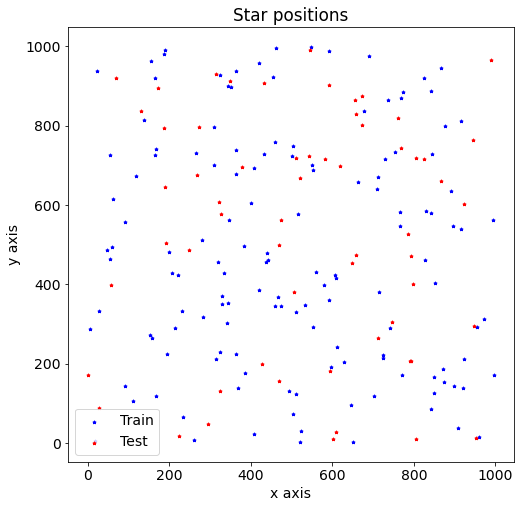

In [14]:
# Check out the positions

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
im1 = ax1.scatter(pos_np[:train_lim,0], pos_np[:train_lim,1], s=10., c='blue', marker='*', label='Train')
im1 = ax1.scatter(pos_np[train_lim:,0], pos_np[train_lim:,1], s=10., c='red', marker='*', label='Test')
ax1.set_title('Star positions')
ax1.set_xlabel('x axis')
ax1.set_ylabel('y axis')
ax1.legend()
plt.show()


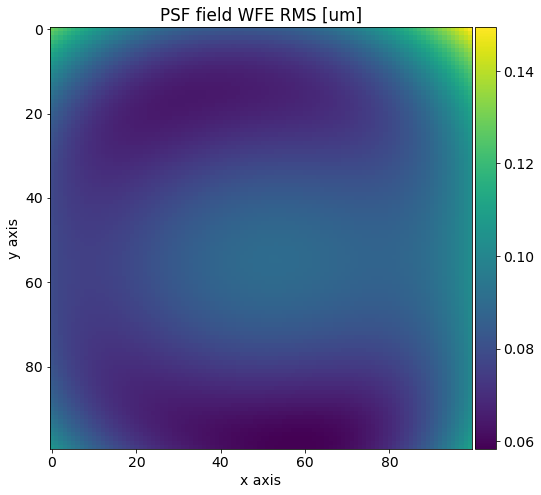

In [15]:
gen_poly_fieldPSF.show_WFE_RMS()


In [16]:
# Generate the PSFs
poly_psf_list = []
opd_list = []
zernike_coef_list = []

for it in tqdm(range(n_stars)):
    _psf, _zernike, _opd = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[it, 0],
                                                          yv_flat=pos_np[it, 1],
                                                          SED=SED_list[it])
    
    poly_psf_list.append(_psf)
    opd_list.append(_opd)
    zernike_coef_list.append(_zernike)


100%|██████████| 200/200 [33:32<00:00, 10.06s/it]


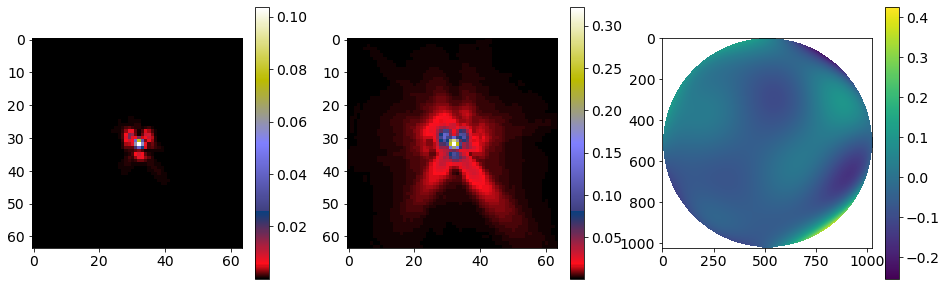

WFE RMS: 0.065411


In [23]:
# Let's inspect one sample from the dataset
_it = 2

figure(figsize=[16,5])
subplot(131)
imshow(poly_psf_list[_it], cmap='gist_stern');colorbar()

subplot(132)
imshow(np.sqrt(poly_psf_list[_it]), cmap='gist_stern');colorbar()

subplot(133)
imshow(opd_list[_it]);colorbar()
plt.savefig('./example_PSF_n%d.pdf'%(_it), bbox_inches='tight')

show()

print('WFE RMS: %f'%(np.sqrt(np.sum(zernike_coef_list[_it]**2))))


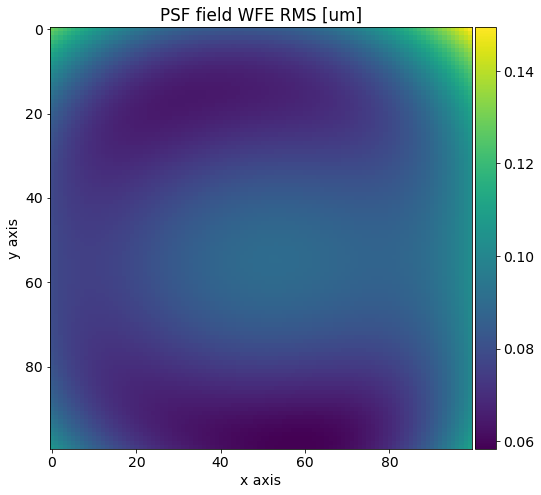

In [19]:
gen_poly_fieldPSF.show_WFE_RMS(save_img=True)

In [24]:
# Generate numpy arrays from the lists
poly_psf_np = np.array(poly_psf_list)
opd_np = np.array(opd_list)
zernike_coef_np = np.array(zernike_coef_list)
SED_np = np.array(SED_list)


In [26]:
print(poly_psf_np.shape)
print(opd_np.shape)
print(zernike_coef_np.shape)
print(SED_np.shape)
print(pos_np.shape)

(200, 64, 64)
(200, 1024, 1024)
(200, 24, 1)
(200, 352, 2)
(200, 2)


In [30]:
# Generate dictionary and save

train_psf_dataset = {'stars' : poly_psf_np[:train_lim, :, :],
                     'positions' : pos_np[:train_lim, :],
                     'SEDs' : SED_np[:train_lim, :, :],
                     'zernike_coef' : zernike_coef_np[:train_lim, :, :],
                     'parameters': dataset_params}

test_psf_dataset = {'stars' : poly_psf_np[train_lim:, :, :],
                     'positions' : pos_np[train_lim:, :],
                     'SEDs' : SED_np[train_lim:, :, :],
                     'zernike_coef' : zernike_coef_np[train_lim:, :, :],
                     'parameters': dataset_params}


In [32]:
output_folder = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/notebooks/psf_field_datasets/'

np.save(output_folder + 'train_psf_field_polynomnial.npy', train_psf_dataset, allow_pickle=True)
np.save(output_folder + 'test_psf_field_polynomnial.npy', test_psf_dataset, allow_pickle=True)


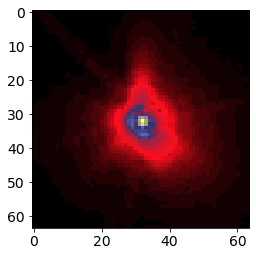

In [33]:
plt.figure()
plt.imshow(np.sqrt(train_psf_dataset['stars'][24,:,:]), cmap='gist_stern')
plt.show()